# Extract transaction database

Here, we will extract transactions to be used for generating association rules. The source dataset is stored in the `../original` directory.

# 1. Examine data quality

First, let's load up the data and take a look at the quality of this dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../original/latestdata.csv.gz', low_memory=False)
print("%s rows x %s columns" % (data.shape[0], data.shape[1]))
data.head()

261558 rows x 34 columns


,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-,30-39,female,Snohomish County,Washington,United States,1.0,48.048180,-121.696000,admin2,...,NaN,NaN,NaN,NaN,Snohomish County,Washington,United States,2988,NaN,NaN
1,000-1-,NaN,NaN,NaN,Khuzestan,Iran,1.0,31.496225,48.967279,admin1,...,NaN,NaN,NaN,NaN,NaN,Khuzestan,Iran,15,NaN,NaN
2,000-1-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000-1-,50-59,male,Snohomish County,Washington,United States,1.0,48.048180,-121.696000,admin2,...,NaN,NaN,NaN,NaN,Snohomish County,Washington,United States,2988,NaN,NaN
4,000-1-,NaN,NaN,NaN,Pays de la Loire,France,1.0,47.486460,-0.811280,admin1,...,NaN,NaN,NaN,NaN,NaN,Pays de la Loire,France,12,NaN,NaN


Okay, looks good, but also a lot of null (NaN) values. Let's count up the data actually present.

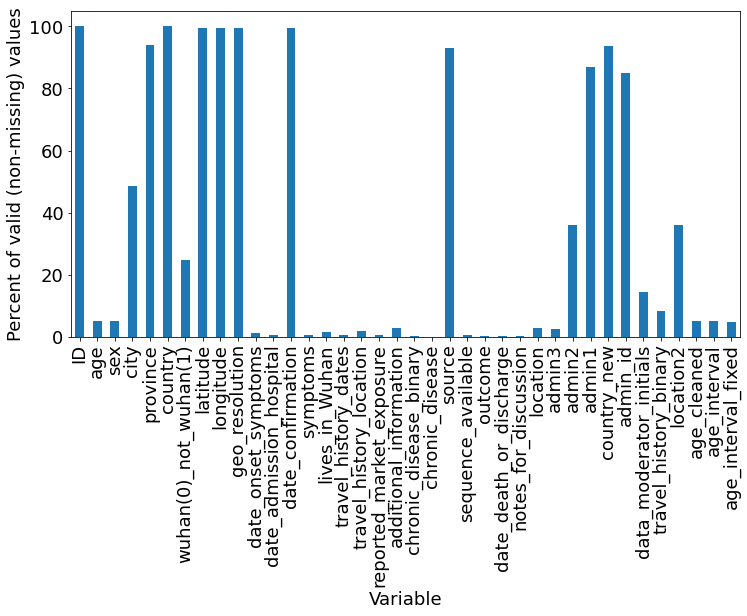

In [29]:
(100*data.count()/len(data)).plot(kind='bar', figsize=(12,6))
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.xlabel('Variable')
plt.ylabel('Percent of valid (non-missing) values')
plt.show()

So, looks like some variables (like ID, province, country) are present in most of the rows of the dataset. But other variables (like symptoms, date_onset_symptoms) have minimal information recorded.

Let's look at a heatmap of what values are present.

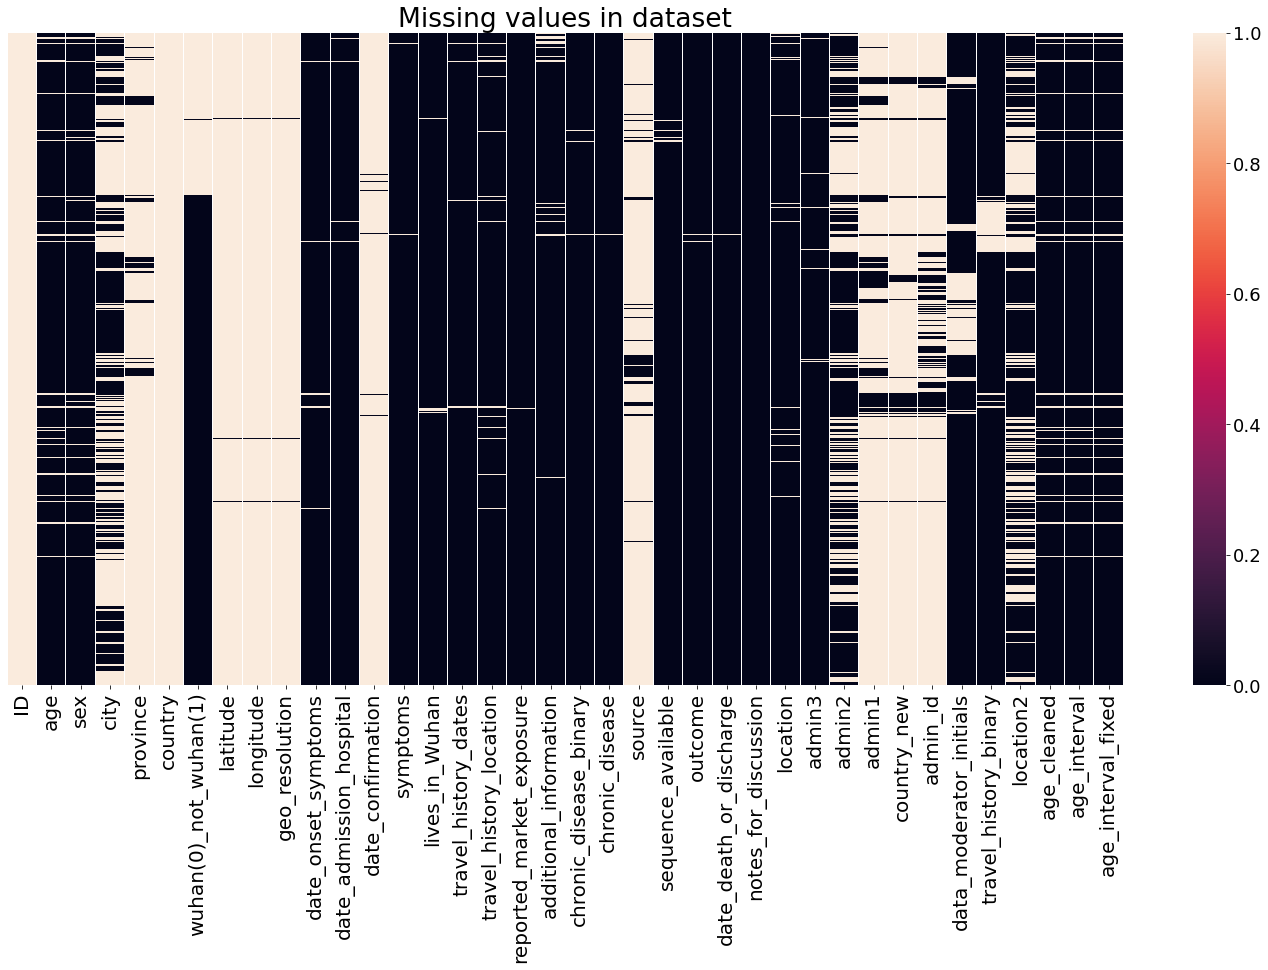

In [31]:
plt.subplots(figsize=(25,12))
#sns.set(font_scale=3.0)
sns.heatmap(~data.isnull(), yticklabels=False)
plt.title('Missing values in dataset')
plt.rc('xtick', labelsize=22)
plt.show()

Black is null, beige is a present data value. This gives us an overview of which missing values correlate with each other.

# 2. Data for mining

Let's now narrow down into some data we will be interested in mining.

In [4]:
data_symptoms=data[['symptoms']].dropna()
data_symptoms

,symptoms
16,"cough, fever, weakness"
137,"cough, diarrhea, fever, rhinorrhoea, sneezing"
151,pneumonitis
164,pneumonitis
224,pneumonitis
...,...
196197,"cough, body aches, chills"
196198,cough
209045,mild
209985,"cough, fever, nausea"


So, we only have around 1500 entries with symptoms associated with them.

Let's look more in-depth at all the unique symptoms listed.

In [5]:
def unique_symptom_counts(df):
    split_symptoms = df['symptoms'].str.split(',').values.tolist()
    unique_symptoms = [item for items in split_symptoms for item in items]
    return {item:unique_symptoms.count(item) for item in unique_symptoms}

def print_symptom_set(s):
    c = 0
    for k,v in s.items():
        if c > 20:
            break
        print(f"'{k}': '{v}'")
        c += 1
    print(f"\nTotal: {len(s)}")
    
unique_symptoms_count = unique_symptom_counts(data_symptoms)
print_symptom_set(unique_symptoms_count)

'cough': '316'
' fever': '282'
' weakness': '10'
' diarrhea': '11'
' rhinorrhoea': '2'
' sneezing': '8'
'pneumonitis': '38'
'anhelation': '2'
' cough': '142'
' pleural effusion': '2'
'diarrhea': '7'
' nasal congestion': '9'
' pleuritic chest pain': '2'
' sore throat': '71'
'fever': '471'
'dizziness': '3'
' sore limbs': '2'
'pneumonia': '20'
' severe pneumonia': '2'
'eye irritation': '1'
' runny nose': '29'

Total: 352


Okay, so there's a bit of cleanup work to do to remove whitespace, and standardize language in symptoms list.

# 3. Data cleaning

Let's try and clean up/standardize the symptoms. Let's look at the one symptom that doesn't appear to be in English.

In [6]:
data_symptoms[data_symptoms['symptoms'].str.contains('moderados')]

,symptoms
150706,"febre, tosse, e sintomas respirat‚àö‚â•rios mo..."


I'm thinking I'll remove it since I don't know the exact translation and it has characters that seemed to be messing up some commands.

In [7]:
symptoms_fix1 = data_symptoms[~data_symptoms['symptoms'].str.contains('moderados')]

Now, let's try and clean up some of the characters.

In [8]:
# Fix up separators between symptoms (sometimes there was , or ; or :)
# Set to lower case
symptoms_fix2 = pd.DataFrame(symptoms_fix1['symptoms'].str.lower().str.replace(
    ', *and', ',').str.replace(
    'and', ',').str.replace(
    ';',',').str.replace(':',',').str.replace(
    ' *,',',').str.replace(', *',','))
print_symptom_set(unique_symptom_counts(symptoms_fix2))

'cough': '526'
'fever': '825'
'weakness': '12'
'diarrhea': '20'
'rhinorrhoea': '2'
'sneezing': '15'
'pneumonitis': '38'
'anhelation': '2'
'pleural effusion': '2'
'nasal congestion': '11'
'pleuritic chest pain': '2'
'sore throat': '110'
'dizziness': '6'
'sore limbs': '2'
'pneumonia': '73'
'severe pneumonia': '6'
'eye irritation': '1'
'runny nose': '45'
'dyspnea': '21'
'difficulty breathing': '6'
'headache': '68'

Total: 260


In [9]:
symptoms_fix3 = pd.DataFrame(symptoms_fix2['symptoms'].str.replace(
    '(37\.5 ℃,then 38 ℃)', '(37.5 ℃ then 38 ℃)').str.replace(
    '[^,]*fever[^,]*', 'fever').str.replace(
    'none', 'no symptoms').str.replace(
    'dcough', 'cough').str.replace(
    'coughing', 'cough').str.replace(
    'dry cough', 'cough').str.replace(
    'cough symptoms', 'cough').str.replace(
    'couh', 'cough').str.replace(
    'sore throath', 'sore throat').str.replace(
    'sore throa[^t]', 'sore throat').str.replace(
    'cough difficulty breathing', 'cough,difficulty breathing').str.replace(
    'mile cough', 'cough').str.replace(
    'mild resipiratory symptoms', 'mild respiratory symptoms').str.replace(
    'mild respiratory symptoms', 'respiratory symptoms').str.replace(
    'symptoms associated with a respiratory condition', 'respiratory symptoms').str.replace(
    'no clinical symptoms', 'no symptoms').str.replace(
    'fatigure', 'fatigue').str.replace(
    'tired', 'fatigue').str.replace(
    'general malaise', 'malaise').str.replace(
    '37\.1 ° c', 'no fever').str.replace(
    'body aches', 'body ache').str.replace(
    'headache\.', 'headache').str.replace(
    'vomiting\.', 'vomiting').str.replace(
    'rhinorrhoea', 'rhinorrhea').str.replace(
    'acute respiratory viral infection \(arvi\)', 'acute respiratory viral infection').str.replace(
    'acute respiratory distress syndrome', 'acute respiratory distress').str.replace(
    'difficuty breathing', 'difficulty breathing').str.replace(
    'asymptomatic\?', 'asymptomatic').str.replace(
    'diarrheoa','diarrhea').str.replace(
    'diarrhoea', 'diarrhea').str.replace(
    'colds', 'cold').str.replace(
    'chest tightness', 'chest pain').str.replace(
    'mialgia', 'muscle pain').str.replace(
    'milagia', 'muscle pain').str.replace(
    'muscle aches', 'muscle pain').str.replace(
    'muscle ache', 'muscle pain').str.replace(
    'respiratory problems \(lungs\)', 'respiratory problems').str.replace(
    'chest discomfort', 'chest pain').str.replace(
    'chest distress', 'chest pain').str.replace(
    'sore throa$', 'sore throat').str.replace(
    'throat discomfort', 'sore throat').str.replace(
    'shortness breath', 'shortness of breath').str.replace(
    'inappetance','inappetence').str.replace(
    'inapatence', 'inappetence').str.replace(
    'lethargy', 'fatigue').str.replace(
    'fatigueness', 'fatigue').str.replace(
    'conjuntivitis','conjunctivitis').str.replace(
    'sneeze', 'sneezing').str.replace(
    'dyspnea', 'shortness of breath').str.replace(
    'dsypnea', 'shortness of breath').str.replace(
    'lack of energy', 'fatigue').str.replace(
    'muscular soreness', 'muscle soreness').str.replace(
    'mausea', 'nausea').str.replace(
    'muscular stiffness', 'muscle soreness').str.replace(
    'severe shortness of breath', 'shortness of breath'))
print_symptom_set(unique_symptom_counts(symptoms_fix3))

'cough': '564'
'fever': '1005'
'weakness': '12'
'diarrhea': '24'
'rhinorrhea': '10'
'sneezing': '17'
'pneumonitis': '38'
'anhelation': '2'
'pleural effusion': '2'
'nasal congestion': '11'
'pleuritic chest pain': '2'
'sore throat': '120'
'dizziness': '6'
'sore limbs': '2'
'pneumonia': '73'
'severe pneumonia': '6'
'eye irritation': '1'
'runny nose': '45'
'shortness of breath': '53'
'difficulty breathing': '10'
'headache': '70'

Total: 142


In [10]:
sorted(list(unique_symptom_counts(symptoms_fix3).keys()))

['abdominal pain',
 'aches',
 'aching muscles',
 'acute coronary syndrome',
 'acute myocardial infarction',
 'acute pharyngitis',
 'acute renal failure',
 'acute respiratory disease',
 'acute respiratory distress',
 'acute respiratory failure',
 'acute respiratory viral infection',
 'afebrile',
 'aggressive pulmonary symptomatology',
 'anhelation',
 'anorexia',
 'asymptomatic',
 'backache',
 'between others',
 'body ache',
 'body malaise',
 'body pain',
 'bone pain',
 'breathing difficulty',
 'cardiac arrhythmia',
 'cardiogenic shock',
 'chest pain',
 'chills',
 'cold',
 'cold chills',
 'congestive heart failure',
 'conjunctivitis',
 'contact of hcov-19/brazil/spbr-01/2020',
 'coriza',
 'cough',
 'covid-19 related symptoms',
 'diarrhea',
 'difficulty breathing',
 'difficulty walking',
 'digestive discomfort',
 'discharge',
 'discomfort',
 'dizziness',
 'dry mouth',
 'dry throat',
 'dysphagia',
 'emesis',
 'esophageal reflux',
 'eventually showed acute left heart failure',
 'expectorati

Making a bit of progress. Let's save this list right now, and maybe revisit later.

# 4. Save symptoms list

In [11]:
expanded_symptoms = symptoms_fix3['symptoms'].str.split(',', expand = True)
expanded_symptoms

,0,1,2,3,4,5
16,cough,fever,weakness,None,None,None
137,cough,diarrhea,fever,rhinorrhea,sneezing,None
151,pneumonitis,None,None,None,None,None
164,pneumonitis,None,None,None,None,None
224,pneumonitis,None,None,None,None,None
...,...,...,...,...,...,...
196197,cough,body ache,chills,None,None,None
196198,cough,None,None,None,None,None
209045,mild,None,None,None,None,None
209985,cough,fever,nausea,None,None,None


Okay, so we now have to convert this into a binary matrix in order to use the specific apriori package for mining. Let's do this now.

In [12]:
def build_binary_matrix(df):
    values_set = {u for v in df.values.tolist() for u in v}
    values_set.remove(None)
    values_list = sorted(list(values_set))
    
    binary_rows = []
    for index, row in df.iterrows():
        binary_row = [index]
        for value in values_list:
            binary_row.append(value in row.values)
        binary_rows.append(binary_row)
        
    values_list.insert(0,'index')
    
    return pd.DataFrame(binary_rows, columns = values_list).set_index('index')

expanded_symptoms_binary = build_binary_matrix(expanded_symptoms)
expanded_symptoms_binary

,abdominal pain,aches,aching muscles,acute coronary syndrome,acute myocardial infarction,acute pharyngitis,acute renal failure,acute respiratory disease,acute respiratory distress,acute respiratory failure,...,sweating,systemic weakness,toothache,transient fatigue,unwellness,vomiting,weak,weakness,wheezing,yes
index,,,,,,,,,,,,,,,,,,,,,
16,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
137,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
151,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
164,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
224,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196197,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
196198,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
209045,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
filename = 'symptoms.tsv'
expanded_symptoms_binary.to_csv(filename, sep="\t", header=True, index=True)
print(f"Wrote to {filename}")

Wrote to symptoms.tsv


# 5. Geographic information for mining

In [14]:
data['location2'] = data['admin2'] + ', ' + data['admin1'] + ', ' + data['country_new']
date_location = data[['date_confirmation', 'location2']].dropna().set_index('location2')
date_location

,date_confirmation
location2,
"Snohomish County, Washington, United States",11.03.2020
"Snohomish County, Washington, United States",11.03.2020
"Snohomish County, Washington, United States",11.03.2020
"Snohomish County, Washington, United States",11.03.2020
"Snohomish County, Washington, United States",11.03.2020
...,...
"Westchester County, New York, United States",08.03.2020
"Westchester County, New York, United States",08.03.2020
"Westchester County, New York, United States",08.03.2020


In [15]:
grouped_date = date_location.groupby('location2').agg(
        {'date_confirmation': lambda x: set(x)})
grouped_date_split = pd.DataFrame(grouped_date['date_confirmation'].values.tolist(), index=grouped_date.index)
grouped_date_split.index = grouped_date_split.index.rename('location')
grouped_date_split

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
location,,,,,,,,,,,,,,,,,,,,,
"Aa en Hunze, Drenthe, Netherlands",22.03.2020,24.03.2020,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
"Aalsmeer, North Holland, Netherlands",19.03.2020,24.03.2020,20.03.2020,23.03.2020,22.03.2020,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
"Aalten, Gelderland, Netherlands",24.03.2020,20.03.2020,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
"Abbeville County, South Carolina, United States",25.03.2020,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
"Abu Dhabi, Abu Dhabi, United Arab Emirates",16.02.2020,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zunyi City, Guizhou, China",07.02.2020,02.02.2020,14.02.2020,31.01.2020,03.02.2020,30.01.2020,06.02.2020,None,None,None,...,None,None,None,None,None,None,None,None,None,None
"Zutphen, Gelderland, Netherlands",24.03.2020,23.03.2020,20.03.2020,21.03.2020,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
"Zwartewaterland, Overijssel, Netherlands",19.03.2020,20.03.2020,24.03.2020,23.03.2020,22.03.2020,21.03.2020,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


To binary matrix.

In [16]:
grouped_date_split_binary = build_binary_matrix(grouped_date_split)
grouped_date_split_binary

,01.02.2020,01.03.2020,02.02.2020,02.03.2020,03.02.2020,03.03.2020,04.02.2020,04.03.2020,05.02.2020,05.03.2020,...,27.02.2020,27.03.2020,28.01.2020,28.02.2020,28.03.2020,29.01.2020,29.02.2020,29.03.2020,30.01.2020,31.01.2020
index,,,,,,,,,,,,,,,,,,,,,
"Aa en Hunze, Drenthe, Netherlands",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"Aalsmeer, North Holland, Netherlands",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"Aalten, Gelderland, Netherlands",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"Abbeville County, South Carolina, United States",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"Abu Dhabi, Abu Dhabi, United Arab Emirates",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zunyi City, Guizhou, China",False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
"Zutphen, Gelderland, Netherlands",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"Zwartewaterland, Overijssel, Netherlands",False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
import csv

filename = "geographic_date.tsv"
grouped_date_split_binary.to_csv(filename, sep="\t", header=True)
print(f"Wrote to file {filename}")

Wrote to file geographic_date.tsv


# Age

In [18]:
data['age_cleaned'] = data['age']
d = data['age'].dropna()
d[d.str.contains('weeks')] = np.NaN
d = d.dropna()
d[d.dropna().str.contains('\.')] = np.NaN
d = d.dropna()
d.value_counts().index.tolist()
data['age_cleaned'] = d
data['age_cleaned'].dropna().value_counts()

50-59    533
60-69    442
40-49    420
30-39    335
70-79    256
        ... 
23-24      1
26-27      1
65-99      1
47-48      1
48-49      1
Name: age_cleaned, Length: 197, dtype: int64

In [19]:
data['age'].dropna()

0         30-39
3         50-59
8         30-39
9         50-59
10        60-69
          ...  
212181    60-69
212192       39
212193       46
212194       45
215423    40-45
Name: age, Length: 13358, dtype: object

In [20]:
import portion as P

def to_interval(v):
    r = v.split('-')
    if len(r) <= 0:
        raise Exception("No value")
    elif len(r) == 1:
        if r[0].isdigit():
            left = int(r[0])
            right = left
        else:
            return np.NaN
    elif len(r) == 2:
        if (not r[0].isdigit()) and (not r[1].isdigit()):
            return np.NaN
        elif r[0].isdigit() and (not r[1].isdigit()):
            v0 = int(r[0])
            v1 = v0
        elif (not r[0].isdigit()) and v[1].isdigit():
            v1 = int(r[1])
            v0 = v1
        else:
            v0 = int(r[0])
            v1 = int(r[1])

        if v0 <= v1:
            left = v0
            right = v1
        else:
            left = v1
            right = v0
    else:
        raise Exception("More than 2 values")

    return P.closed(left, right)

data['age_interval'] = data['age_cleaned']
data['age_interval'] = data['age_interval'].dropna().apply(to_interval)
data['age_interval']

0         ((([30,39])))
1                   NaN
2                   NaN
3         ((([50,59])))
4                   NaN
              ...      
261553              NaN
261554              NaN
261555              NaN
261556              NaN
261557              NaN
Name: age_interval, Length: 261558, dtype: object

In [21]:
def in_intervals_list(value, interval_list):
    for i in interval_list:
        if value in i:
            return True
    return False

interval_list = [
    P.closed(0,9),
    P.closed(10,19),
    P.closed(20,29),
    P.closed(30,39),
    P.closed(40,49),
    P.closed(50,59),
    P.closed(60,69),
    P.closed(70,79),
    P.closed(80,89),
    P.closed(90,99),
    P.closed(100,109),
    P.closed(110,119),
    P.closed(120,129)
]

d = data['age_interval'].dropna()
for age_interval in interval_list:
    d[d.apply(lambda x: x in age_interval)] = age_interval

print("Values not in intervals list (which will be set to NA)")
print(d[~d.apply(lambda x: in_intervals_list(x, interval_list))])

d[~d.apply(lambda x: in_intervals_list(x, interval_list))] = np.NaN

interval_type = pd.CategoricalDtype(
    categories = list(map(lambda x: str(x.lower) + '-' + str(x.upper), interval_list)),
    ordered = True)
data['age_interval_fixed'] = np.NaN
data['age_interval_fixed'] = d.dropna().apply(lambda x: str(x.lower) + '-' + str(x.upper))
data['age_interval_fixed'] = data['age_interval_fixed'].astype(interval_type)
data['age_interval_fixed']

Values not in intervals list (which will be set to NA)
19         ((([8,68])))
20         ((([8,68])))
21         ((([8,68])))
22         ((([8,68])))
23         ((([8,68])))
              ...      
210180    ((([61,80])))
210191    ((([61,80])))
210202    ((([61,80])))
210213    ((([61,80])))
211576    ((([61,80])))
Name: age_interval, Length: 774, dtype: object


0         30-39
1           NaN
2           NaN
3         50-59
4           NaN
          ...  
261553      NaN
261554      NaN
261555      NaN
261556      NaN
261557      NaN
Name: age_interval_fixed, Length: 261558, dtype: category
Categories (13, object): [0-9 < 10-19 < 20-29 < 30-39 ... 90-99 < 100-109 < 110-119 < 120-129]

In [22]:
data[['age', 'age_interval_fixed']].dropna()

,age,age_interval_fixed
0,30-39,30-39
3,50-59,50-59
8,30-39,30-39
9,50-59,50-59
10,60-69,60-69
...,...,...
212181,60-69,60-69
212192,39,30-39
212193,46,40-49
212194,45,40-49


# Now let's aggregate ages by geographic region

In [23]:
age_location = data[['age_interval_fixed', 'location2']].dropna().set_index('location2')
age_location

,age_interval_fixed
location2,
"Snohomish County, Washington, United States",30-39
"Snohomish County, Washington, United States",50-59
"Snohomish County, Washington, United States",30-39
"Snohomish County, Washington, United States",50-59
"Snohomish County, Washington, United States",60-69
...,...
"Clark County, Nevada, United States",40-49
"Clark County, Nevada, United States",60-69
"Westchester County, New York, United States",40-49


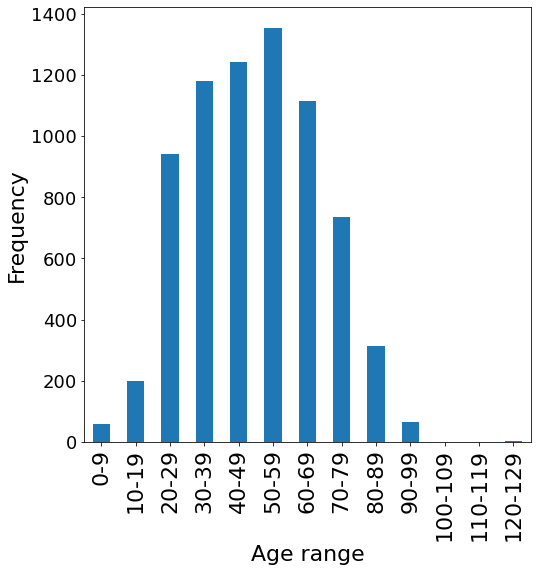

In [32]:
age_location['age_interval_fixed'].value_counts(sort=False).plot(kind='bar', figsize=(8,8))
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.xlabel('Age range')
plt.ylabel('Frequency')
plt.show()

In [25]:
grouped_age = age_location.groupby('location2').agg(
        {'age_interval_fixed': lambda x: sorted(list(set(x)))})
grouped_age_split = pd.DataFrame(grouped_age['age_interval_fixed'].values.tolist(), index=grouped_age.index)
grouped_age_split.index = grouped_age_split.index.rename('location')
grouped_age_split

,0,1,2,3,4,5,6,7,8,9,10
location,,,,,,,,,,,
"Abu Dhabi, Abu Dhabi, United Arab Emirates",30-39,None,None,None,None,None,None,None,None,None,None
"Ada County, Idaho, United States",50-59,None,None,None,None,None,None,None,None,None,None
"Adams County, Colorado, United States",50-59,None,None,None,None,None,None,None,None,None,None
"Alachua County, Florida, United States",0-9,20-29,30-39,40-49,50-59,60-69,70-79,90-99,None,None,None
"Alameda County, California, United States",30-39,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
"Zhoukou City, Henan, China",50-59,None,None,None,None,None,None,None,None,None,None
"Zhuhai City, Guangdong, China",40-49,60-69,70-79,None,None,None,None,None,None,None,None
"Zigong City, Sichuan, China",30-39,40-49,50-59,60-69,None,None,None,None,None,None,None


In [26]:
grouped_age_split_binary = build_binary_matrix(grouped_age_split)
grouped_age_split_binary

,0-9,10-19,120-129,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99
index,,,,,,,,,,,
"Abu Dhabi, Abu Dhabi, United Arab Emirates",False,False,False,False,True,False,False,False,False,False,False
"Ada County, Idaho, United States",False,False,False,False,False,False,True,False,False,False,False
"Adams County, Colorado, United States",False,False,False,False,False,False,True,False,False,False,False
"Alachua County, Florida, United States",True,False,False,True,True,True,True,True,True,False,True
"Alameda County, California, United States",False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
"Zhoukou City, Henan, China",False,False,False,False,False,False,True,False,False,False,False
"Zhuhai City, Guangdong, China",False,False,False,False,False,True,False,True,True,False,False
"Zigong City, Sichuan, China",False,False,False,False,True,True,True,True,False,False,False


## Save ages to file

In [27]:
import csv

filename = "geographic_age.tsv"
grouped_age_split_binary.to_csv(filename, sep="\t", header=True)
print(f"Wrote to file {filename}")

Wrote to file geographic_age.tsv
